# SpatialDataIntegration_SpatialProteomicsData2

This tutorial demonstrates how to spatial data integration on spatial proteomics data2 using Pysodb and STAGATE+Harmony.

The reference paper can be found at https://www.nature.com/articles/s41467-022-29439-6 (STAGATE), https://www.nature.com/articles/s41592-019-0619-0 (Harmony) and https://www.science.org/doi/10.1126/science.aar7042 (spatial proteomics data2).

## Import packages and set configurations

In [1]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import several Python packages commonly used in data analysis and visualization:
# pandas (imported as pd) is a package for data manipulation and analysis
import pandas as pd
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization
import matplotlib.pyplot as plt

In [3]:
# Import a STAGATE_pyG module
import STAGATE_pyG as STAGATE

If users encounter the error "No module named 'STAGATE_pyG'" when trying to import STAGATE_pyG package, first ensure that the "STAGATE_pyG" folder is located in the current script's directory.

In [4]:
# Imports a palettable package
import palettable
# Create two variables with lists of colors for categorical visualizations and biotechnology-related visualizations, respectively.
cmp_old = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cmp_old_biotech = palettable.cartocolors.qualitative.Safe_4.mpl_colors

## Streamline development of loading spatial data with Pysodb

In [5]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [6]:
# Initialization
sodb = pysodb.SODB()

In [7]:
# Define a section_list with samples from different experiments
section_list = ['cell_129', 'cell_143', 'cell_140', 'cell_127']

In [8]:
# Download experiments into adata_list using pysodb
dataset_name = 'gut2018multiplexed'
adata_list = {}
for section_id in section_list:
    temp_adata = sodb.load_experiment(dataset_name,section_id)
    temp_adata.var_names_make_unique()
    temp_adata.obs_names = [x+'_'+section_id for x in temp_adata.obs_names]

    adata_list[section_id] = temp_adata.copy()

load experiment[cell_129] in dataset[gut2018multiplexed]
load experiment[cell_143] in dataset[gut2018multiplexed]
load experiment[cell_140] in dataset[gut2018multiplexed]
load experiment[cell_127] in dataset[gut2018multiplexed]


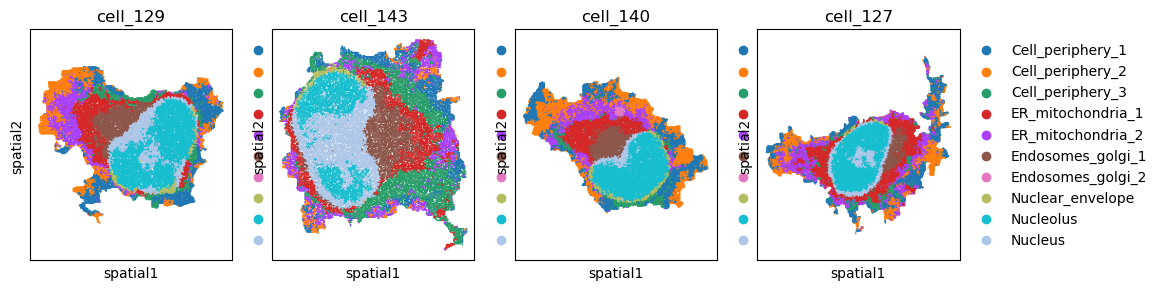

In [9]:
# Visualize different experiments color by 'cluster'
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_list:
    if it == 3:
        ax = sc.pl.embedding(adata_list[section_id], basis= 'spatial', ax=axs[it],
                      color=['cluster'], title=section_id, show=False)
        ax.axis('equal')
    else:
        ax = sc.pl.embedding(adata_list[section_id], basis= 'spatial', ax=axs[it], 
                      color=['cluster'], title=section_id, show=False)
        ax.axis('equal')
    it+=1

## Running STAGATE for training

------Calculating spatial graph...
The graph contains 331176 edges, 15213 cells.
21.7693 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 418616 edges, 19053 cells.
21.9711 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 464924 edges, 21371 cells.
21.7549 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 552110 edges, 25415 cells.
21.7238 neighbors per cell on average.


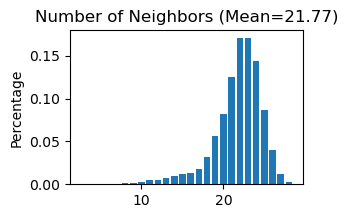

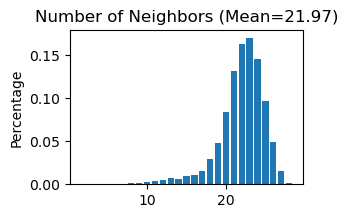

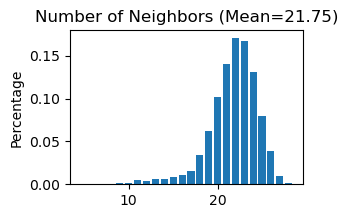

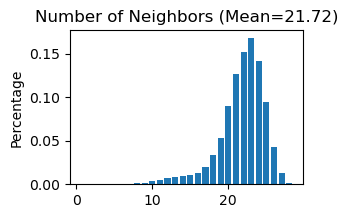

In [10]:
# Use "STAGATE_pyG.Cal_Spatial_Net" to calculate spatial graph for different samples 
# And use "STAGATE_pyG.Stats_Spatial_Net" to summarize their cells and edges information
for section_id in section_list:
    STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=3)
    STAGATE.Stats_Spatial_Net(adata_list[section_id])

In [11]:
# Train the STAGATE model on each individual sample in the adata_list
for section_id in section_list:
    adata_list[section_id] = STAGATE.train_STAGATE(adata_list[section_id],n_epochs= 1500)

Size of Input:  (15213, 43)


100%|██████████| 1500/1500 [00:34<00:00, 43.69it/s]


Size of Input:  (19053, 43)


100%|██████████| 1500/1500 [00:42<00:00, 35.49it/s]


Size of Input:  (21371, 43)


100%|██████████| 1500/1500 [00:47<00:00, 31.85it/s]


Size of Input:  (25415, 43)


100%|██████████| 1500/1500 [00:55<00:00, 26.92it/s]


In [12]:
# Concatenate each individual sample in the adata_list into a AnnData object named 'adata_before'
adata_before = sc.concat([adata_list[x] for x in section_list], keys=None)

In [13]:
# Calculate the nearest neighbors in the 'STAGATE' representation and computes the UMAP embedding.
sc.pp.neighbors(adata_before, use_rep='STAGATE')
sc.tl.umap(adata_before)

In [14]:
# Use Mclust_R to cluster cells in the 'STAGATE' representation into 10 clusters.
adata_before = STAGATE.mclust_R(adata_before, used_obsm='STAGATE', num_cluster=10)
adata_before.obs['mclust10_before'] = adata_before.obs['mclust']

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [15]:
# Concatenate each individual sample in the adata_list into another new AnnData object named 'adata'
adata = sc.concat([adata_list[x] for x in section_list], keys=None)

In [16]:
# Save UMAP and mclust clustering results before integration
adata.obsm['UMAP_before'] = adata_before.obsm['X_umap']
adata.obs['mclust10_before'] = adata_before.obs['mclust10_before']

In [17]:
# Delete the STAGATE embedding from each individual sample
del adata.obsm['STAGATE']

In [18]:
# Concatenate all 'Spatial_Net'
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net'] for x in section_list])

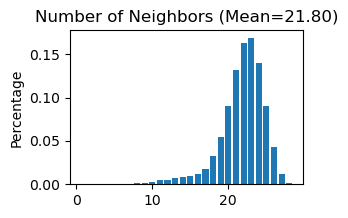

In [19]:
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information for whole adata
STAGATE.Stats_Spatial_Net(adata)

In [20]:
# Train the STAGATE model on the whole samples
adata = STAGATE.train_STAGATE(adata, n_epochs= 1500)

Size of Input:  (81052, 43)


100%|██████████| 1500/1500 [02:57<00:00,  8.44it/s]


In [21]:
# Create a new column 'Sample' by splitting each name and selecting the last two element
adata.obs['Sample'] = [x.split('_')[-2] + '_' + x.split('_')[-1] for x in adata.obs_names]

In [22]:
adata.obs['Sample'] 

747877_cell_129    cell_129
708635_cell_129    cell_129
728396_cell_129    cell_129
784709_cell_129    cell_129
768447_cell_129    cell_129
                     ...   
814036_cell_127    cell_127
728906_cell_127    cell_127
657777_cell_127    cell_127
702680_cell_127    cell_127
778308_cell_127    cell_127
Name: Sample, Length: 81052, dtype: object

<Axes: title={'center': 'Unintegrated'}, xlabel='UMAP_before1', ylabel='UMAP_before2'>

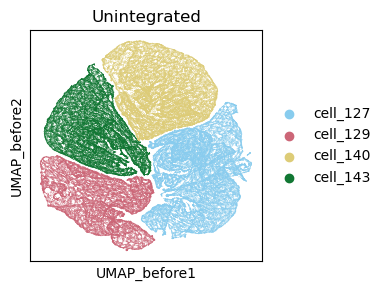

In [23]:
# Plot a UMAP projection before integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_before', color='Sample', title='Unintegrated',show=False, palette=cmp_old_biotech)

<Axes: title={'center': 'mclust10_before'}, xlabel='UMAP_before1', ylabel='UMAP_before2'>

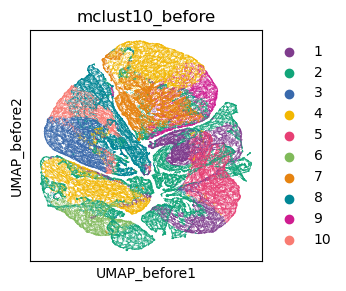

In [24]:
# Generate a plot of the UMAP embedding colored by mclust before integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_before', color='mclust10_before', show=False, palette=cmp_old)

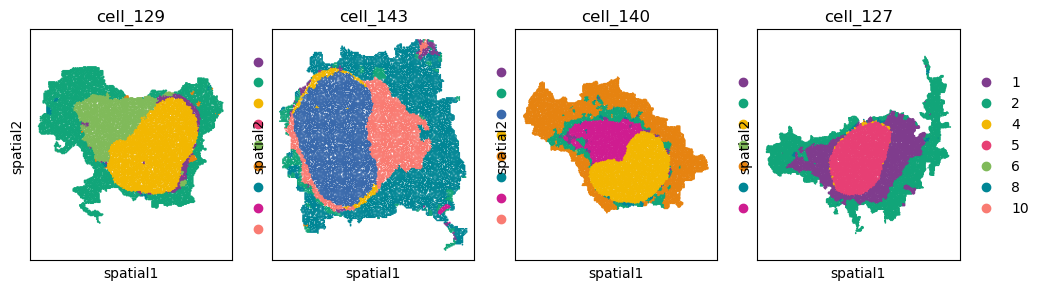

In [25]:
# Display spatial distribution of cells colored by mclust clustering for four samples
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_list:
    if it == 3:
        ax = sc.pl.embedding(adata[adata.obs['Sample']==section_id], basis= 'spatial', ax=axs[it],
                      color=['mclust10_before'], title=section_id, show=False)
        ax.axis('equal')
    else:
        ax = sc.pl.embedding(adata[adata.obs['Sample']==section_id], basis= 'spatial', ax=axs[it], 
                      color=['mclust10_before'], title=section_id, show=False)
        ax.axis('equal')
    it+=1

## Perform Harmony for spatial data intergration

Harmony is an algorithm for integrating multiple high-dimensional datasets
It can be employed as a reference at https://github.com/slowkow/harmonypy and https://pypi.org/project/harmonypy/

In [26]:
# Import harmonypy package
import harmonypy as hm

In [27]:
# Use STAGATE representation to create 'meta_data' for harmony
data_mat = adata.obsm['STAGATE'].copy()
meta_data = adata.obs.copy()

In [28]:
# Run harmony for STAGATE representation
ho = hm.run_harmony(data_mat, meta_data, ['Sample'])

2023-07-15 09:15:02,591 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2023-07-15 09:15:11,568 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-07-15 09:15:11,799 - harmonypy - INFO - Iteration 1 of 10
2023-07-15 09:15:28,517 - harmonypy - INFO - Iteration 2 of 10
2023-07-15 09:15:45,385 - harmonypy - INFO - Iteration 3 of 10
2023-07-15 09:16:02,717 - harmonypy - INFO - Iteration 4 of 10
2023-07-15 09:16:19,980 - harmonypy - INFO - Iteration 5 of 10
2023-07-15 09:16:31,743 - harmonypy - INFO - Iteration 6 of 10
2023-07-15 09:16:41,966 - harmonypy - INFO - Iteration 7 of 10
2023-07-15 09:16:48,974 - harmonypy - INFO - Iteration 8 of 10
2023-07-15 09:16:55,928 - harmonypy - INFO - Iteration 9 of 10
2023-07-15 09:17:04,016 - harmonypy - INFO - Converged after 9 iterations


In [29]:
# Write the adjusted PCs to a new file.
res = pd.DataFrame(ho.Z_corr)
res.columns = adata.obs_names

In [30]:
# Creates a new AnnData object adata_Harmony using a transpose of the res matrix
adata_Harmony = sc.AnnData(res.T)

In [31]:
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Sample'] = adata.obs.loc[adata_Harmony.obs_names, 'Sample']

In [32]:
# Calculate the nearest neighbors in the 'STAGATE' representation and computes the UMAP embedding for the integrated data
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)

In [33]:
# Use Mclust_R to cluster cells in the 'Harmony' representation into 4 clusters.
adata_Harmony.obsm['Harmony'] = adata_Harmony.X
adata_Harmony = STAGATE.mclust_R(adata_Harmony, used_obsm='Harmony', num_cluster=4)
adata_Harmony.obs['mclust4_after'] = adata_Harmony.obs['mclust']

fitting ...
  |======================================================================| 100%


In [34]:
# Save UMAP and mclust clustering results after integration
adata.obsm['UMAP_after'] = adata_Harmony.obsm['X_umap']
adata.obs['mclust4_after'] = adata_Harmony.obs['mclust4_after']

<Axes: title={'center': 'STAGATE + Harmony'}, xlabel='UMAP_after1', ylabel='UMAP_after2'>

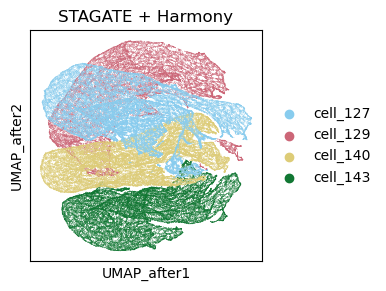

In [35]:
# Plot a UMAP projection different samples after integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_after', color='Sample', title='STAGATE + Harmony',show=False, palette=cmp_old_biotech)

<Axes: title={'center': 'mclust4_after'}, xlabel='UMAP_after1', ylabel='UMAP_after2'>

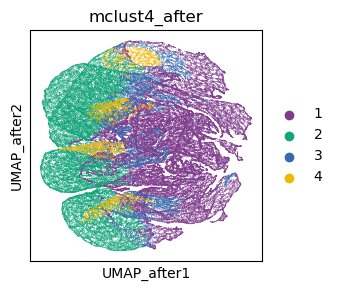

In [36]:
# Generate a plot of the UMAP embedding colored by mclust after integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis= 'UMAP_after', color='mclust4_after', show=False, palette=cmp_old)

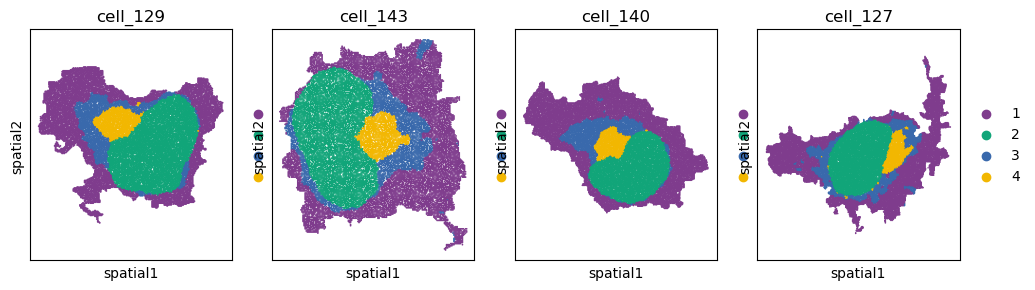

In [37]:
# Display spatial distribution of cells colored by mclust clustering for four samples after integration
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_list:
    if it == 3:
        ax = sc.pl.embedding(adata[adata.obs['Sample']==section_id], basis= 'spatial', ax=axs[it],
                      color=['mclust4_after'], title=section_id, show=False)
        ax.axis('equal')
    else:
        ax = sc.pl.embedding(adata[adata.obs['Sample']==section_id], basis= 'spatial', ax=axs[it], 
                      color=['mclust4_after'], title=section_id, show=False)
        ax.axis('equal')
    it+=1